In [1]:
import pandas as pd
import prepare as pr

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
import unicodedata
import re
# import modules
import env
from wordcloud import WordCloud

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
from importlib import reload

In [6]:
df = pr.get_clean_df()

In [5]:
# numerical
'''
df['original_length'] = df.original.str.len()
df['clean_length'] = df.clean.str.len()
df['length_diff'] = df.original_length - df.clean_length
df['lem_length'] = df.lemmatized.str.len()
# categorical
df['has_#9'] = np.where(df.clean.str.contains('&#9;'), 1, 0)
df['has_parts'] = np.where((df.clean.str.contains(' parts ')) | (df.clean.str.contains(' parts ')), 1, 0)
df['has_fix'] = np.where(df.clean.str.contains(' fix '), 1, 0)
df['has_tab'] = np.where(df.clean.str.contains(' tab '), 1, 0)
df['has_x'] = np.where(df.clean.str.contains(' x '), 1, 0)
df['has_v'] = np.where(df.clean.str.contains(' v '), 1, 0)
df['has_codeblock'] = np.where(df.clean.str.contains('codeblock'), 1, 0)
df['has_image'] = np.where(df.clean.str.contains('image'), 1, 0)
'''

"\ndf['original_length'] = df.original.str.len()\ndf['clean_length'] = df.clean.str.len()\ndf['length_diff'] = df.original_length - df.clean_length\ndf['lem_length'] = df.lemmatized.str.len()\n# categorical\ndf['has_#9'] = np.where(df.clean.str.contains('&#9;'), 1, 0)\ndf['has_parts'] = np.where((df.clean.str.contains(' parts ')) | (df.clean.str.contains(' parts ')), 1, 0)\ndf['has_fix'] = np.where(df.clean.str.contains(' fix '), 1, 0)\ndf['has_tab'] = np.where(df.clean.str.contains(' tab '), 1, 0)\ndf['has_x'] = np.where(df.clean.str.contains(' x '), 1, 0)\ndf['has_v'] = np.where(df.clean.str.contains(' v '), 1, 0)\ndf['has_codeblock'] = np.where(df.clean.str.contains('codeblock'), 1, 0)\ndf['has_image'] = np.where(df.clean.str.contains('image'), 1, 0)\n"

In [ ]:
def scale_numeric_data(X_train, X_validate, X_test):
    '''
    Scales numerical columns.
    Parameters:
        train, validate, test data sets
    Returns:
    train, validate, test data sets with scaled data
    '''
    # features to scale
    to_scale = ['sentiment', 'lem_length', 'original_length',  'length_diff','clean_length']
    # create a scaler
    sc = MinMaxScaler()
    sc.fit(X_train[to_scale])
    # transform data
    X_train[to_scale] = sc.transform(X_train[to_scale])
    X_validate[to_scale] = sc.transform(X_validate[to_scale])
    X_test[to_scale] = sc.transform(X_test[to_scale])
    
    return X_train, X_validate, X_test

In [20]:
reload(pr)

<module 'prepare' from '/Users/nadina/codeup-data-science/Codeup-Mirzakhani-GitHub-Scrape-NLP-Project/prepare.py'>

In [21]:
df = pr.get_clean_df()

In [22]:
df.head(1)

,original,first_clean,clean,lemmatized,sentiment,lem_length,original_length,length_diff,has_#9,has_tab,has_parts,has_fix,has_x,has_v,has_codeblock,has_image,language
0,"<p align=""center""><img src=""https://live.stati...",SpaceX REST API Open Source REST API for lau...,spacex rest api open source rest api launch ro...,spacex rest api open source rest api launch ro...,0.7717,475,7208,6713,0,0,0,0,0,0,0,1,JavaScript


In [24]:
X_train, X_validate, X_test, y_train, y_validate, y_test = pr.split_data(df, explore=False)

In [27]:
X_train.head(1)

,original,first_clean,clean,lemmatized,sentiment,lem_length,original_length,length_diff
271,[![Build Status](https://travis-ci.org/guardia...,[![Build Status,build status,build status,0.456904,0.000618,0.262251,0.262051


In [47]:
reload(pr)

<module 'prepare' from '/Users/nadina/codeup-data-science/Codeup-Mirzakhani-GitHub-Scrape-NLP-Project/prepare.py'>

In [7]:
X_train, X_validate, X_test, y_train, y_validate, y_test = pr.split_data(df, explore=False)

In [8]:
X_train.head(1)

,lemmatized,sentiment,lem_length,original_length,length_diff
271,build status,0.456904,0.000618,0.262251,0.262051


In [9]:
def get_additional_stopwords(ser: pd.Series) -> list:
    '''
    Vectorizes the Series, calculates IDF, creates a list of values where idf score is bigger than 5.65.
    This list can be used as stopwords for creating Bag of Words
    Parameters:
        ser: pandas series or data frame column that contains text
    Returns:
        list of strings -> stopwords
    '''
    tv = TfidfVectorizer()
    tv.fit(ser)
    idf_values = pd.Series(
        dict(
            zip(
                tv.get_feature_names_out(), tv.idf_)))
    # get the list of stop words
    # 5.65 -> sweet spot
    return idf_values[idf_values > 5.65].index.tolist()

In [33]:
# get_additional_stopwords(X_train.lemmatized) # works

In [27]:
def vectorize(train_ser: pd.Series, validate_ser: pd.Series, test_ser: pd.Series, stopwords: list[str]):
    '''
    Applies TfidfVectorizer to text column from train, validate and test data sets.
    Creates Bag of Words
    
    Parameters:
        train_ser: train[column to vectorize]
        validate_ser: validate[column to vectorize]
        test_ser: test[column to vectorize]
        stopwords: list of stopwords that should not be included in the bag of words
    Returns:
        3 data frames train/validate/test with bag of words 
    '''
    # create a vectorizer with stop words
    tv = TfidfVectorizer(stop_words=stopwords)
    # fit transform train 
    train_tv = tv.fit_transform(train_ser)
    # transform validate
    validate_tv = tv.transform(validate_ser)
    # transform test
    test_tv = tv.transform(test_ser)
    
    # create Bag of Words data frames
    # for column names extract features
    # for index us series indexes
    XF_train = pd.DataFrame(train_tv.todense(),
                            columns=tv.get_feature_names_out(),
                           index = train_ser.index)
    XF_validate = pd.DataFrame(validate_tv.todense(), 
                               columns=tv.get_feature_names_out(),
                              index=validate_ser.index)
    XF_test = pd.DataFrame(test_tv.todense(), 
                           columns=tv.get_feature_names_out(),
                          index=test_ser.index)
    
    
    return XF_train, XF_validate, XF_test

In [28]:
XF_train, XF_validate, XF_test = vectorize(X_train.lemmatized, X_validate.lemmatized, X_test.lemmatized, get_additional_stopwords(X_train.lemmatized))

In [31]:
(XF_train.index != train_num.index).sum()

0

Try to separate `lemmatized` from numbers

In [13]:
train_ser = X_train.lemmatized
validate_ser = X_validate.lemmatized
test_ser = X_test.lemmatized

In [14]:
train_num = X_train.drop('lemmatized', axis = 1)
validate_num = X_validate.drop('lemmatized', axis = 1)
test_num = X_test.drop('lemmatized', axis = 1)

In [15]:
scores = pd.DataFrame(columns=['model_name', 'parameters', 'train_score', 'validate_score', 'difference'])

In [67]:
#scores.loc[len(scores)] = []

In [20]:
import tensorflow as tf

2023-01-12 19:00:49.641623: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
def get_modeling_data(df):
    '''
    
    '''
    # get splitted data sets and target variables
    X_train, X_validate, X_test, y_train, y_validate, y_test = pr.split_data(df, explore=False)
    # create series from lemmatized text column
    train_ser = X_train.lemmatized
    validate_ser = X_validate.lemmatized
    test_ser = X_test.lemmatized
    # separate numerical columns
    train_num = X_train.drop('lemmatized', axis = 1)
    validate_num = X_validate.drop('lemmatized', axis = 1)
    test_num = X_test.drop('lemmatized', axis = 1)
    # create bag of words using vectorize function
    XF_train, XF_validate, XF_test = vectorize(train_ser, 
                                               validate_ser, 
                                               test_ser, 
                                               get_additional_stopwords(train_ser))
    # concatenate bag of words and numerical values 
    X_train_complete = pd.concat([XF_train, train_num], axis=1)                            
    X_validate_complete = pd.concat([XF_validate, validate_num], axis=1)                             
    X_test_complete = pd.concat([XF_test, test_num], axis=1)
    
    return X_train_complete, X_validate_complete, X_test_complete, y_train, y_validate, y_test

In [43]:
X_train, X_validate, X_test, y_train, y_validate, y_test = get_modeling_data(df)

In [45]:
X_train.isnull().sum().sum()

0

In [ ]:
X_train_complete = pd.concat([train_num, 
                                  pd.DataFrame(train_ser, columns=column_names, index=train_num.index)], 
                                  axis=1)
    X_validate_complete = pd.concat([validate_num, 
                                     pd.DataFrame(validate_ser, columns=column_names, index=validate_num.index)], 
                                    axis=1)
    X_test_complete = pd.concat([test_num, pd.DataFrame(test_ser, columns=column_names, index=test_num.index)], 
              axis=1)

In [46]:
reload(pr)

<module 'prepare' from '/Users/nadina/codeup-data-science/Codeup-Mirzakhani-GitHub-Scrape-NLP-Project/prepare.py'>

### Actiual modeling part

In [45]:
X_train, X_validate, X_test, y_train, y_validate, y_test = pr.get_modeling_data()

In [46]:
X_train.shape, X_validate.shape, X_test.shape

((241, 1621), (104, 1621), (87, 1621))

In [47]:
X_train

,ab,ability,able,access,accessed,accompanying,according,account,accuracy,accurate,...,yellow,yet,yield,youtube,zero,zip,sentiment,lem_length,original_length,length_diff
271,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.456904,0.000618,0.262251,0.262051
344,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.540160,0.038384,0.027498,0.007324
23,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.456904,0.007368,0.075758,0.071957
190,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.498885,0.016951,0.172625,0.163941
22,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.456904,0.004276,0.006309,0.004021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.048725,0.002422,0.114036,0.112836
123,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.238349,0.000361,0.094445,0.094301
242,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.456904,0.005049,0.467591,0.465166
183,0.0,0.0,0.0,0.009846,0.012366,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.999837,0.623474,0.633135,0.307696


In [48]:
import pandas as pd
import prepare as pr

In [49]:
from sklearn.model_selection import GridSearchCV

In [50]:
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression

In [51]:
seed = 42

In [52]:
# create scores
scores = pd.DataFrame(columns=['model_name', 'train_score', 'validate_score', 'score_difference'])

##### Random Forest

In [65]:
rf_parameters = {'max_depth':[6,8,10],
                  'min_samples_leaf':[2, 3, 5]
             }

In [66]:
rf = RandomForestClassifier(random_state=seed)

In [67]:
grid_rf = GridSearchCV(estimator=rf, param_grid=rf_parameters, cv=3, n_jobs=-1)

In [68]:
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [6, 8, 10],
                         'min_samples_leaf': [2, 3, 5]})

In [69]:
grid_rf.best_params_

{'max_depth': 10, 'min_samples_leaf': 2}

In [187]:
grid_rf.best_estimator_

RandomForestClassifier(max_depth=10, min_samples_leaf=2, random_state=42)

In [72]:
rf = RandomForestClassifier(max_depth=10, min_samples_leaf=3, random_state=seed)
rf.fit(X_train, y_train)
rf.score(X_train, y_train)

0.6970954356846473

In [73]:
 rf.score(X_validate, y_validate)

0.49038461538461536

In [191]:
print(f'Random Forest Parameters:  {grid_rf.best_params_}')

Random Forest Parameters:  {'max_depth': 10, 'min_samples_leaf': 2}


In [53]:
def run_random_forest(cv:int=3):
    '''
    Classifier: Random Forest algorithm
    Creates a dictionary of parameters for the classifier 
    Uses GridSearchCV to find the best combination of parameters
    Prints the selected parameters on the screen
    Fits the classifier with best parameters to the training set using GridSearch
    Calculates accuracy scores for the training and validate sets and saves them into scores dataframe
    -----------
    Parameters:
        cv: integer, number of cross validation folds for the grid search
    No returns
    '''
    # create a dictionary of parameters
    rf_parameters = {'max_depth':[5, 6, 7],
                  'min_samples_leaf':[2, 3, 5]
             }
    # create a classifier
    rf = RandomForestClassifier(random_state=seed)
    # creat a grid search
    grid_rf = GridSearchCV(estimator=rf, param_grid=rf_parameters, cv=cv, n_jobs=-1)
    # fit on train set
    grid_rf.fit(X_train, y_train)
    # print the best parameter's comination
    print(f'Random Forest Parameters:  {grid_rf.best_params_}')
    # calculate scores
    train_score = grid_rf.best_estimator_.score(X_train, y_train)
    validate_score = grid_rf.best_estimator_.score(X_validate, y_validate)
    # save the scores into a dataframe
    scores.loc[len(scores)] = ['Random Forest', train_score, validate_score, train_score - validate_score]

In [196]:
run_random_forest(5)

Random Forest Parameters:  {'max_depth': 5, 'min_samples_leaf': 2}


In [197]:
scores

,model_name,train_score,validate_score,score_difference
0,Random Forest,0.709544,0.490385,0.219159
1,Random Forest,0.634855,0.480769,0.154086


##### Gradient Boosting

In [74]:
gb = GradientBoostingClassifier(random_state=seed)

In [75]:
GradientBoostingClassifier?

In [77]:
gb_parameters = {
    'learning_rate': [0.1, 0.3, 0.5],
    'n_estimators': [100, 150, 200],
    'max_depth': [6, 8, 10],
}
grid_gb = GridSearchCV(estimator=gb, param_grid=gb_parameters, cv=2, n_jobs=-1)
grid_gb.fit(X_train, y_train)

In [176]:
grid_gb = GridSearchCV(estimator=gb, param_grid=gb_parameters, cv=2, n_jobs=-1)

In [178]:
grid_gb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(learning_rate=0.2,
                                                  max_depth=6,
                                                  random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.3, 0.5],
                         'max_depth': [6, 8, 10], 'min_samples_leaf': [2, 3, 5],
                         'n_estimators': [100, 150, 200]})

In [179]:
grid_gb.best_estimator_

GradientBoostingClassifier(max_depth=6, min_samples_leaf=2, n_estimators=150,
                           random_state=42)

In [115]:
gb = GradientBoostingClassifier(learning_rate=0.2, max_depth=6, min_samples_leaf=1, n_estimators=100, random_state=seed)

In [180]:
#grid_gb.fit(X_train, y_train)
grid_gb.best_estimator_.score(X_train, y_train)

0.983402489626556

In [181]:
grid_gb.best_estimator_.score(X_validate, y_validate)

0.46153846153846156

In [54]:
def run_gradient_boosting(cv=3):
    '''
    Classifier: Gradient Boosting
    Creates a dictionary of parameters for the classifier 
    Uses GridSearchCV to find the best combination of parameters
    Prints the selected parameters on the screen
    Fits the classifier with best parameters to the training set using GridSearch
    Calculates accuracy scores for the training and validate sets and saves them into scores dataframe
    -----------
    Parameters:
        cv: integer, number of cross validation folds for the grid search
    No returns
    '''
    # create a dictionary of parameters
    gb_parameters = {
        'learning_rate': [0.1, 0.2, 0.3],
        'n_estimators': [100, 150, 200],
        'max_depth': [5, 6, 7],
    }
    # create a classifier
    gb = GradientBoostingClassifier(random_state=seed)
    # create a grid search
    grid_gb = GridSearchCV(estimator=gb, param_grid=gb_parameters, cv=cv, n_jobs=-1)
    # fit on train set
    grid_gb.fit(X_train, y_train)
    # print the best parameter's comination
    print(f'Gradient Boosting Parameters:  {grid_gb.best_params_}')
    # calculate scores
    train_score = grid_gb.best_estimator_.score(X_train, y_train)
    validate_score = grid_gb.best_estimator_.score(X_validate, y_validate)
    # save scores 
    scores.loc[len(scores)] = ['Gradient Boosting', train_score, validate_score, train_score - validate_score]

In [202]:
run_gradient_boosting()

Gradient Boosting Parameters:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}


In [203]:
scores

,model_name,train_score,validate_score,score_difference
0,Random Forest,0.709544,0.490385,0.219159
1,Random Forest,0.634855,0.480769,0.154086
2,Gradient Boosting,0.983402,0.471154,0.512249
3,Gradient Boosting,0.983402,0.509615,0.473787


##### XGBoost

In [119]:
xb_parameters = {
    'max_depth': [3, 4, 5, 6],
    'gamma': [0.1, 0.2, 0.5]
}

In [134]:
xb = xgb.XGBClassifier(n_estimators=100,eval_metric='merror',seed=seed)

In [129]:
grid_xb = GridSearchCV(estimator=xb, param_grid=xb_parameters, cv=2, n_jobs=-1)

In [61]:
lang_map = {'Java':0, 'C#':1, 'JavaScript':2, 'Python':3}

In [62]:
y_train_numeric = y_train.map(lang_map)
y_validate_numeric = y_validate.map(lang_map)
y_test_numeric = y_test.map(lang_map)

In [132]:
grid_xb.fit(X_train, y_train_numeric)

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='merror', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                    

In [150]:
grid_xb.best_params_

{'gamma': 0.5, 'max_depth': 3}

In [147]:
xb = xgb.XGBClassifier(n_estimators=100,eval_metric='merror',gamma=0.5, max_depth=3, seed=seed)

In [148]:
xb.fit(X_train, y_train_numeric)
xb.score(X_train, y_train_numeric)

0.9336099585062241

In [149]:
xb.score(X_validate, y_validate_numeric)

0.5288461538461539

In [161]:
def modelfit(alg, X_train, y_train, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train.values, label=y_train_numeric.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='merror', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train_numeric,eval_metric='merror')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)
    dtrain_predprob = alg.predict_proba(X_train)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [163]:
#modelfit(xb, X_train, y_train_numeric)

In [168]:
xgb.plot_importance?

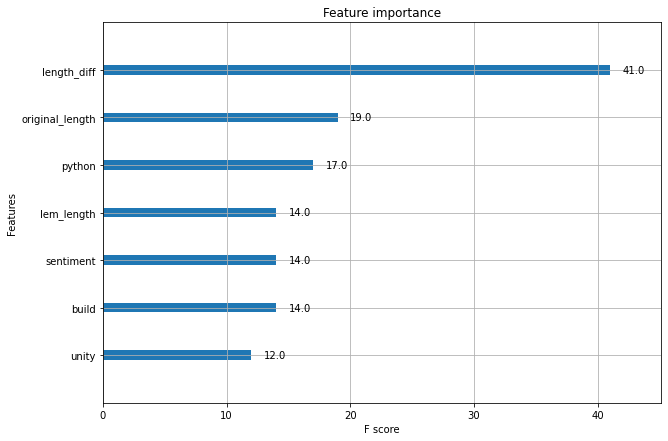

In [173]:
import matplotlib.pyplot as plt
xgb.plot_importance(xb, max_num_features=7)
plt.rcParams['figure.figsize'] = [10,7]
plt.show()

In [67]:
def run_xgboost(cv=3):
    '''
    Classifier: XGBoost
    Creates a dictionary of parameters for the classifier 
    Uses GridSearchCV to find the best combination of parameters
    Prints the selected parameters on the screen
    Fits the classifier with best parameters to the training set using GridSearch
    Calculates accuracy scores for the training and validate sets and saves them into scores dataframe
    Prints Feature Importance bar chart
    -----------
    Parameters:
        cv: integer, number of cross validation folds for the grid search
    No returns
    '''
    # create parameters
    xb_parameters = {
        'max_depth': [3, 4, 5, 6],
        'gamma': [0.1, 0.2, 0.3]
    }
    # create a classifier
    xb = xgb.XGBClassifier(n_estimators=100,eval_metric='merror',seed=seed)
    # create a grid search
    grid_xb = GridSearchCV(estimator=xb, param_grid=xb_parameters, cv=cv, n_jobs=-1)
    # fit on the train set
    grid_xb.fit(X_train, y_train_numeric)
    # print parameters
    print(f'XGBoost Parameters:  {grid_xb.best_params_}')
    print()
    # calculate scores
    train_score = grid_xb.best_estimator_.score(X_train, y_train_numeric)
    validate_score = grid_xb.best_estimator_.score(X_validate, y_validate_numeric)
    # add scores to the dataframe
    scores.loc[len(scores)] = ['XGBoost', train_score, validate_score, train_score - validate_score]
    # create a braplot and display it
    # because the plot needs the classifier to be fit first directly, not through the grid search
    # we create the classifier again using the best parameters {'gamma': 0.2, 'max_depth': 4}
    xb = xgb.XGBClassifier(gamma=0.2, max_depth=4 ,n_estimators=100,eval_metric='merror',seed=seed)
    xb.fit(X_train, y_train_numeric)
    xgb.plot_importance(xb, max_num_features=7)
    plt.rcParams['figure.figsize'] = [10,7]
    plt.show()

XGBoost Parameters:  {'gamma': 0.2, 'max_depth': 4}



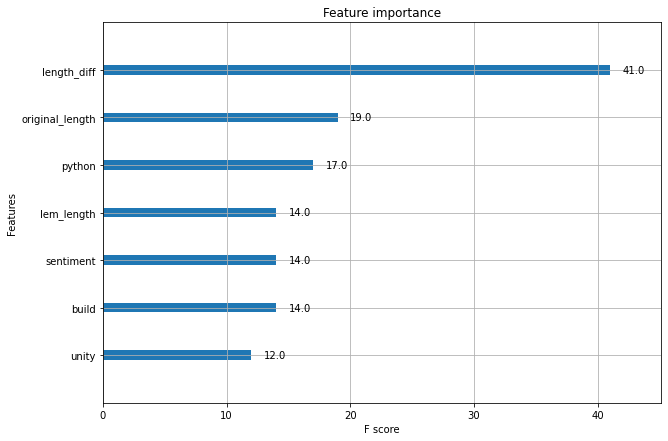

In [216]:
run_xgboost()

##### Logistic Regression

In [38]:
lr = LogisticRegression(random_state=seed)
lr.fit(X_train, y_train)
train_score_lr = lr.score(X_train, y_train)
validate_score_lr = lr.score(X_validate, y_validate)
scores.loc[len(scores)] = \
    ['Logistic Regression', train_score_lr, validate_score_lr, train_score_lr - validate_score_lr]

In [39]:
validate_score_lr = lr.score(X_validate, y_validate)

In [25]:
scores.loc[len(scores)] = \
    ['Logistic Regression', train_score_lr, validate_score_lr, train_score_lr - validate_score_lr]

In [26]:
scores

,model_name,train_score,validate_score,score_difference
0,Logistic Regression,0.86722,0.548077,0.319143


In [28]:
mnb = MultinomialNB(alpha=0.2)

In [68]:
def run_multinomial_nb(cv:int=3):
    '''
    Classifier: Multinomial Naive Bayes
    Creates a dictionary of parameters for the classifier 
    Uses GridSearchCV to find the best combination of parameters
    Prints the selected parameters on the screen
    Fits the classifier with best parameters to the training set using GridSearch
    Calculates accuracy scores for the training and validate sets and saves them into scores dataframe
    -----------
    Parameters:
        cv: integer, number of cross validation folds for the grid search
    No returns
    '''
    mnb_parameters = {'alpha': [0.2, 0.5, 1.0]}
    mnb = MultinomialNB(alpha=0.2)
    grid_mnb = GridSearchCV(estimator=mnb, param_grid=mnb_parameters, cv=cv, n_jobs=-1)
    # fit on the train set
    grid_mnb.fit(X_train, y_train)
    # print parameters
    print(f'Multinomial NB Parameters:  {grid_mnb.best_params_}')
    # calculate scores
    train_score = grid_mnb.best_estimator_.score(X_train, y_train)
    validate_score = grid_mnb.best_estimator_.score(X_validate, y_validate)
    # add scores to the dataframe
    scores.loc[len(scores)] = ['Multinomail Naive Bayes', train_score, validate_score, train_score - validate_score]

In [41]:
scores

,model_name,train_score,validate_score,score_difference
0,Logistic Regression,0.867220,0.548077,0.319143
1,Multinomail Naive Bayes,0.892116,0.586538,0.305578
2,Multinomail Naive Bayes,0.892116,0.586538,0.305578
3,Gaussian Naive Bayes,0.879668,0.509615,0.370053


In [33]:
run_multinomial_nb(5)

Multinomial NB Parameters:  {'alpha': 0.2}



In [40]:
nb = GaussianNB()
nb.fit(X_train, y_train)
train_score_nb = nb.score(X_train, y_train)
validate_score_nb = nb.score(X_validate, y_validate)
scores.loc[len(scores)] = \
    ['Gaussian Naive Bayes', train_score_nb, validate_score_nb, train_score_nb - validate_score_nb]

In [36]:
MultinomialNB?

In [70]:
def run_other():
    '''
    Classifier #1: Logistic Regression
    Classifier #2: Gaussian Naive Bayes
    Creates Logistic Regression and Gaussian NB, fits them on the training set
    Calculates accuracy scores for the training and validate sets and saves them into scores dataframe
    -----------
    No parameters
    No returns
    '''
    ##### STEP 1
    # create Logistic Regression
    lr = LogisticRegression(random_state=seed)
    # fit on the train set
    lr.fit(X_train, y_train)
    # calculate scores
    train_score_lr = lr.score(X_train, y_train)
    validate_score_lr = lr.score(X_validate, y_validate)
    # print params
    print('Logistic Regression: default paramters')
    # save the scores
    scores.loc[len(scores)] = \
        ['Logistic Regression', train_score_lr, validate_score_lr, train_score_lr - validate_score_lr]
    
    ##### STEP 2
    # create Gaussian NB
    nb = GaussianNB()
    # fit on the train set
    nb.fit(X_train, y_train)
    # calculate scores
    train_score_nb = nb.score(X_train, y_train)
    validate_score_nb = nb.score(X_validate, y_validate)
    # print params
    print('Gaussian NB parameters: default paramters')
    # save the scores
    scores.loc[len(scores)] = \
        ['Gaussian Naive Bayes', train_score_nb, validate_score_nb, train_score_nb - validate_score_nb]

In [43]:
run_other()

In [44]:
scores

,model_name,train_score,validate_score,score_difference
0,Logistic Regression,0.867220,0.548077,0.319143
1,Multinomail Naive Bayes,0.892116,0.586538,0.305578
2,Multinomail Naive Bayes,0.892116,0.586538,0.305578
3,Gaussian Naive Bayes,0.879668,0.509615,0.370053
4,Logistic Regression,0.867220,0.548077,0.319143
5,Gaussian Naive Bayes,0.879668,0.509615,0.370053


In [58]:
def run_decision_tree(cv:int=3):
    '''
    Classifier: Decision Tree algorithm
    Creates a dictionary of parameters for the classifier
        Uses GridSearchCV to find the best combination of parameters
    Prints the selected parameters on the screen
    Fits the classifier with best parameters to the training set using GridSearch
    Calculates accuracy scores for the training and validate sets and saves them into scores dataframe
    -----------
    Parameters:
        cv: integer, number of cross validation folds for the grid search
    No returns
    '''
    # create a dictionary of parameters
    DTC_parameters = {'max_depth':[ 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 ]
                     }
    # create a classifier
    DTC = DecisionTreeClassifier(random_state=seed)
    # creat a grid search
    grid_DTC = GridSearchCV(estimator=DTC, param_grid=DTC_parameters, cv=cv, n_jobs=-1)
    # fit on train set
    grid_DTC.fit(X_train, y_train)
    # print the best parameter's comination
    print(f'Best parameters per algorithm:')
    print('------------------------------------------------------------------------------------------------------------------------------------')
    print(f'Decision Tree Parameters:  {grid_DTC.best_params_}')
    # calculate scores
    train_score = grid_DTC.best_estimator_.score(X_train, y_train)
    validate_score = grid_DTC.best_estimator_.score(X_validate, y_validate)
    # save the scores into a dataframe
    scores.loc[len(scores)] = ['Decision Tree', train_score, validate_score, train_score - validate_score]

In [72]:
def run_all_classifiers() -> pd.DataFrame:
    '''
    Runs all classifiers.
    No returns
    '''
    run_decision_tree()
    run_random_forest()
    run_other() # 2 classifiers
    run_multinomial_nb()
    run_gradient_boosting()
    run_xgboost()

In [77]:
scores.sort_values(by='score_difference')
#scores

,model_name,train_score,validate_score,score_difference
1,Random Forest,0.634855,0.480769,0.154086
21,Random Forest,0.634855,0.480769,0.154086
14,Random Forest,0.634855,0.480769,0.154086
7,Random Forest,0.634855,0.480769,0.154086
0,Decision Tree,0.622407,0.461538,0.160868
20,Decision Tree,0.622407,0.461538,0.160868
13,Decision Tree,0.622407,0.461538,0.160868
6,Decision Tree,0.622407,0.461538,0.160868
8,Multinomail Naive Bayes,0.892116,0.586538,0.305578
24,Multinomail Naive Bayes,0.892116,0.586538,0.305578


In [78]:
run_random_forest(5)

Random Forest Parameters:  {'max_depth': 5, 'min_samples_leaf': 2}


In [81]:
def run_best_model():
    rf = RandomForestClassifier(max_depth=5, min_samples_leaf=2, random_state=seed)
    rf.fit(X_train, y_train)
    #calculate scores
    train_score = round(rf.score(X_train, y_train), 2)
    validate_score = round(rf.score(X_validate, y_validate), 2)
    test_score = round(rf.score(X_test, y_test), 2)
    yhat=rf.predict(X_test)
    return pd.DataFrame({'result':['Random Forest', train_score, validate_score, test_score]},\
                          index=['Model name', 'Train score', 'Validate score', 'Test score'])

In [82]:
run_best_model()

,result
Model name,Random Forest
Train score,0.63
Validate score,0.48
Test score,0.59


In [84]:
run_best_model()

,result
Model name,Random Forest
Train score,0.98
Validate score,0.53
Test score,0.55


In [87]:
from importlib import reload

In [90]:
reload(md)

<module 'modeling' from '/Users/nadina/codeup-data-science/Codeup-Mirzakhani-GitHub-Scrape-NLP-Project/modeling.py'>

In [85]:
import modeling as md

In [91]:
md.run_all_classifiers()

Best parameters per algorithm:
----------------------------------------------------
Decision Tree Parameters:  {'max_depth': 6}
Random Forest Parameters:  {'max_depth': 5, 'min_samples_leaf': 2}
Logistic Regression: default paramters
Gaussian NB parameters: default paramters
Multinomial NB Parameters:  {'alpha': 0.2}
Gradient Boosting Parameters:  {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 150}
XGBoost Parameters:  {'gamma': 0.2, 'max_depth': 4}



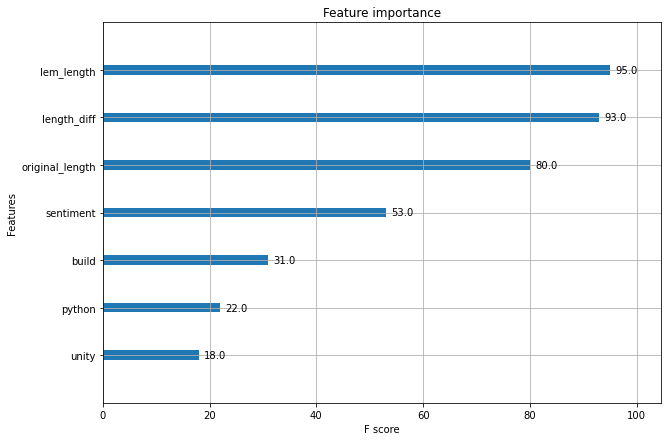

In [92]:
md.display_feature_importance()

In [93]:
md.display_scores()

,model_name,train_score,validate_score,score_difference
1,Random Forest,0.634855,0.480769,0.154086
0,Decision Tree,0.622407,0.461538,0.160868
4,Multinomail Naive Bayes,0.892116,0.586538,0.305578
2,Logistic Regression,0.867220,0.548077,0.319143
3,Gaussian Naive Bayes,0.879668,0.509615,0.370053
5,Gradient Boosting,0.983402,0.548077,0.435326
6,XGBoost,0.979253,0.528846,0.450407


In [94]:
md.run_best_model()

,result
Model name,Random Forest
Train score,0.63
Validate score,0.48
Test score,0.59


In [1]:
%who

Interactive namespace is empty.
